# Model LGBM

# 0. Setup

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import geohash

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from rdforecast import datasets

path = './input/'
data = datasets.load_training_data()
print('TAZ:', len(data['geohash6'].unique()))
data = datasets.convert_datetime(data)
data.head()

N: 4206321
TAZ: 1329


geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468

In [5]:
counts = data['geohash6'].value_counts()
counts = dict(zip(counts.index, counts.values))
max_count = 61 * 24 * 4

In [6]:
data['dow'] = data['day'] % 7
dow = data.groupby(['dow', 'time']).mean()[['demand']]
dow = dow.reset_index()

In [20]:
# X = daily_demand_mean.values
taz_demand = data['geohash6'].value_counts()
sample = taz_demand.index[100]
sample = data[data['geohash6'] == sample].sort_values(['datetime'])
X = sample['demand'].values

sample['day'] = (sample['day'] - 1) % 7
print(sample['day'].value_counts())
sample['weekend'] = int(sample['day'] > 4)

4    864
2    863
1    863
0    861
3    851
5    761
6    758
Name: day, dtype: int64


In [11]:
taz_daily = data.groupby(['geohash6', 'day'])['demand'].sum().reset_index()
taz_daily = taz_daily.pivot(index='geohash6', columns='day', values='demand')
taz_daily.fillna(0, inplace=True)
assert sum(taz_daily.sum(axis=1) == 0) == 0

# standardize
tazmean = taz_daily.mean(axis=1)
tazstd = taz_daily.std(axis=1)
taz_daily = taz_daily.apply(lambda x: (x - tazmean) / tazstd)
taz_daily['active_count'] = taz_daily.index.map(counts) / max_count
taz_daily.head()

day              1         2         3         4         5         6  \
geohash6                                                               
qp02yc   -0.810720 -0.553245 -0.502718  0.408039 -0.802496 -1.007065   
qp02yf   -0.421247 -0.136156  0.290865 -0.245631 -0.329872 -0.001902   
qp02yu   -0.135846 -0.135846 -0.135846 -0.135846 -0.135846 -0.135846   
qp02yv   -0.197097 -0.197097 -0.197097 -0.197097  0.284647 -0.197097   
qp02yy   -0.128547  0.389281 -0.249925  0.554634 -0.328009  0.121216   

day              7         8         9        10      ...             53  \
geohash6                                              ...                  
qp02yc    0.352295 -0.445095  0.938419 -0.544423      ...       1.866856   
qp02yf    0.248657 -0.421247 -0.234069 -0.115328      ...      -0.421247   
qp02yu   -0.135846 -0.135846 -0.135846 -0.135846      ...      -0.135846   
qp02yv   -0.197097 -0.197097 -0.197097 -0.197097      ...      -0.197097   
qp02yy   -0.333908 -0.340643  0.595424 -0.408952      ...      -0.408952   

day             54        55        56        57        58        59  \
geohash6                                                               
qp02yc   -0.589964 -0.958830  0.397738  0.461034 -0.491166  4.514224   
qp02yf   -0.396947 -0.421247  0.525120 -0.421247 -0.402783  0.021777   
qp02yu    0.347395 -0.135846 -0.135846 -0.135846 -0.135846  7.667498   
qp02yv   -0.197097 -0.197097 -0.197097 -0.197097 -0.197097 -0.197097   
qp02yy    0.111999 -0.351073  0.091913 -0.274491 -0.396727 -0.408952   

day             60        61  active_count  
geohash6                                    
qp02yc    2.272901  0.909376      0.098531  
qp02yf    0.060569 -0.171389      0.015198  
qp02yu   -0.135846 -0.135846      0.000342  
qp02yv   -0.197097 -0.197097      0.001195  
qp02yy    0.223138  0.130987      0.018101  

[5 rows x 62 columns]

In [12]:
taz_quarterly = data.groupby(['geohash6', 'timestamp'])['demand'].mean().reset_index()

ts = taz_quarterly['timestamp'].unique()
h, m = zip(*[t.split(':') for t in ts])
h = np.array([int(i) for i in h])
m = np.array([(int(i) / 60) for i in m])
ts_num = h + m
ts_to_num = dict(zip(ts, ts_num))

taz_quarterly['timestamp'] = taz_quarterly['timestamp'].map(ts_to_num)
taz_quarterly = taz_quarterly.pivot(index='geohash6', columns='timestamp', values='demand')
taz_quarterly.fillna(0, inplace=True)
assert sum(taz_quarterly.sum(axis=1) == 0) == 0

# standardize
tazmean = taz_quarterly.mean(axis=1)
tazstd = taz_quarterly.std(axis=1)
taz_quarterly = taz_quarterly.apply(lambda x: (x - tazmean) / tazstd)
taz_quarterly['active_count'] = taz_quarterly.index.map(counts) / max_count
taz_quarterly.head()

timestamp       0.0      0.25       0.5      0.75       1.0      1.25  \
geohash6                                                                
qp02yc     0.817159  0.050268 -1.099626 -0.366929  0.393077  1.279391   
qp02yf    -0.085207 -0.592257 -0.592257  0.491229  2.053358 -0.512706   
qp02yu    -0.108246 -0.108246 -0.108246 -0.108246 -0.108246 -0.108246   
qp02yv    -0.207141 -0.207141 -0.207141 -0.207141 -0.207141 -0.207141   
qp02yy     0.184683  3.063896  4.494958  0.729941 -0.068113  0.285598   

timestamp       1.5      1.75       2.0      2.25      ...          21.75  \
geohash6                                               ...                  
qp02yc    -0.359270 -0.092664  1.007797  1.120308      ...      -1.099626   
qp02yf     0.725651 -0.592257 -0.592257  0.018750      ...      -0.592257   
qp02yu    -0.108246 -0.108246 -0.108246 -0.108246      ...      -0.108246   
qp02yv    -0.207141 -0.207141 -0.207141 -0.207141      ...      -0.207141   
qp02yy     0.558304 -0.246825  0.212538 -0.531758      ...      -0.531758   

timestamp      22.0     22.25      22.5     22.75      23.0     23.25  \
geohash6                                                                
qp02yc    -1.099626 -0.755862 -0.469505  0.511916 -0.082454  0.710992   
qp02yf    -0.592257 -0.592257 -0.592257 -0.592257 -0.592257 -0.592257   
qp02yu    -0.108246 -0.108246 -0.108246 -0.108246 -0.108246 -0.108246   
qp02yv    -0.207141 -0.207141 -0.207141 -0.207141 -0.207141 -0.207141   
qp02yy    -0.531758 -0.531758 -0.531758  1.336675  0.953458 -0.531758   

timestamp      23.5     23.75  active_count  
geohash6                                     
qp02yc    -0.599751 -0.005873      0.098531  
qp02yf     1.723108 -0.000469      0.015198  
qp02yu    -0.108246 -0.108246      0.000342  
qp02yv    -0.207141 -0.207141      0.001195  
qp02yy    -0.531758 -0.531758      0.018101  

[5 rows x 97 columns]

In [13]:
from sklearn.cluster import KMeans

# define a function that does K-means clustering and plot the results
def plotKM(df, n_timesteps, n_features, n_clusters, random_state=2019):
    """
    Arg:
        1. df: df to cluster (as dataframe)
        2. n_clusters: number of clusters
        3. random: seed number for random_state
    Return:
        1. append labels back to df as label_km'n'
        2. plot cluster result
    """
    print('Last feature:', df.columns[n_features - 1])
    
    # run K-means and assign results
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    res = km.fit(df.iloc[:, :n_features])
    df['label_km{}'.format(n_clusters)] = res.labels_
    
    # plot results
    plt.figure(figsize=(16,10))

    for l in range(n_clusters):
        # subset df and calculate means for each label
        df_ = df[df['label_km{}'.format(n_clusters)] == l]
        df_means = df_.mean(axis=0)
        
        plt.subplot(np.ceil(n_clusters/2), 2, 1+l)
        for i in range(len(df_)):
            plt.plot(range(n_timesteps), df_.iloc[i, :n_timesteps], 'steelblue', alpha=0.2)
            plt.plot(range(n_timesteps), df_means[:n_timesteps], 'indianred', linewidth=2)
        plt.xticks(np.arange(0, n_timesteps, 4), rotation=45)
        plt.title('KM Cluster Label: {} (n = {})'.format(l, len(df_)))

    plt.tight_layout()
    plt.show()

Last feature: active_count


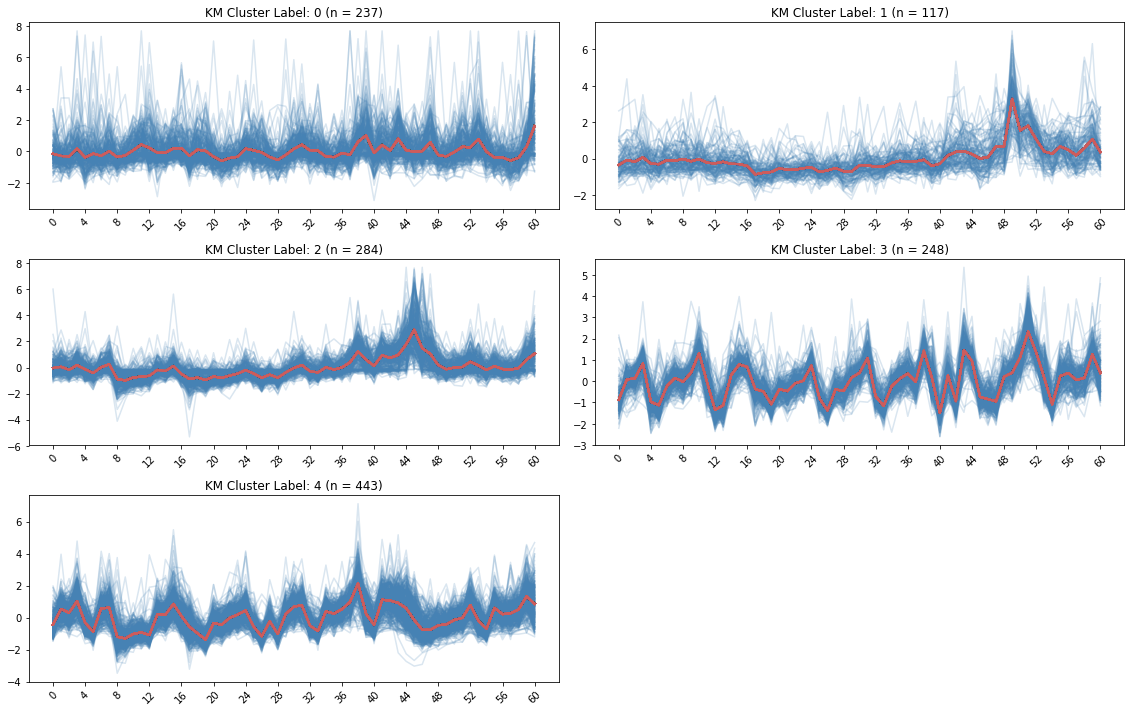

Last feature: active_count


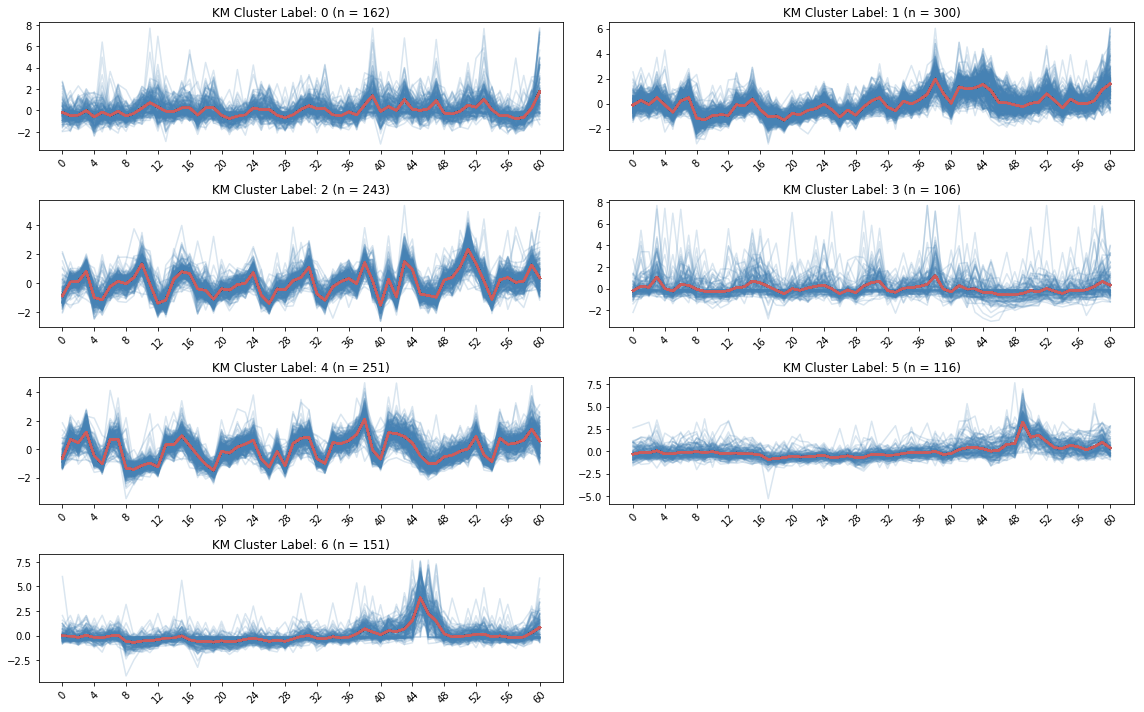

Last feature: active_count


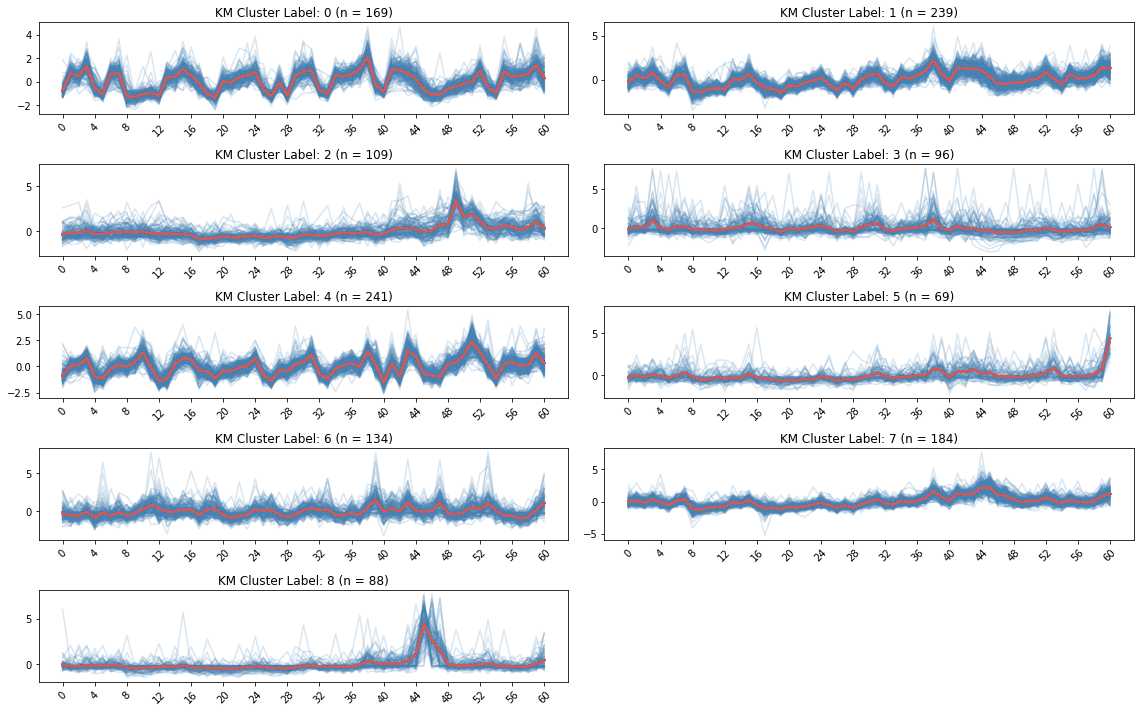

In [14]:
n_timesteps = 61
n_features = 62
plotKM(taz_daily, n_timesteps, n_features, 9)

Last feature: active_count


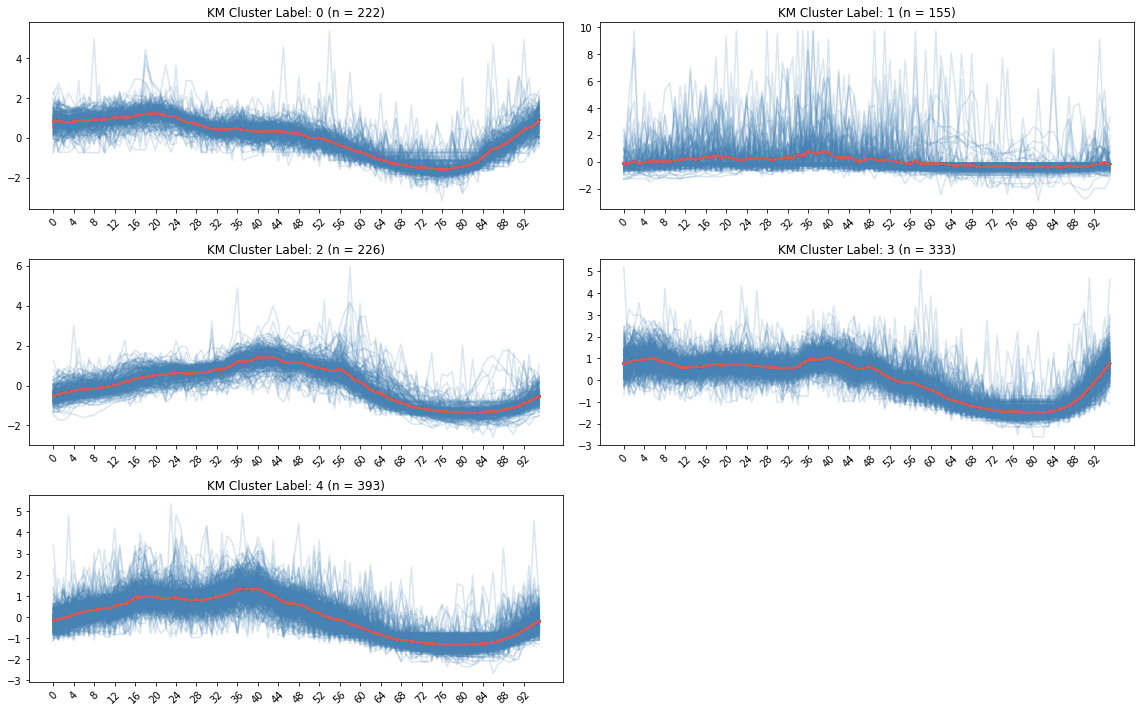

Last feature: active_count


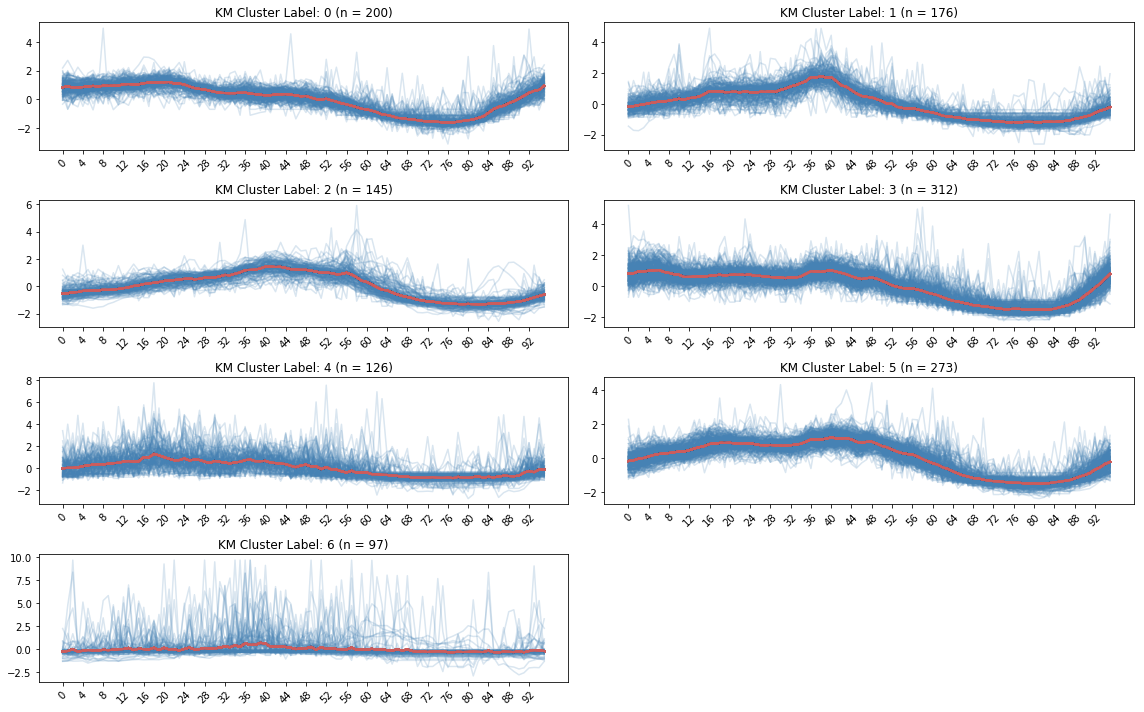

Last feature: active_count


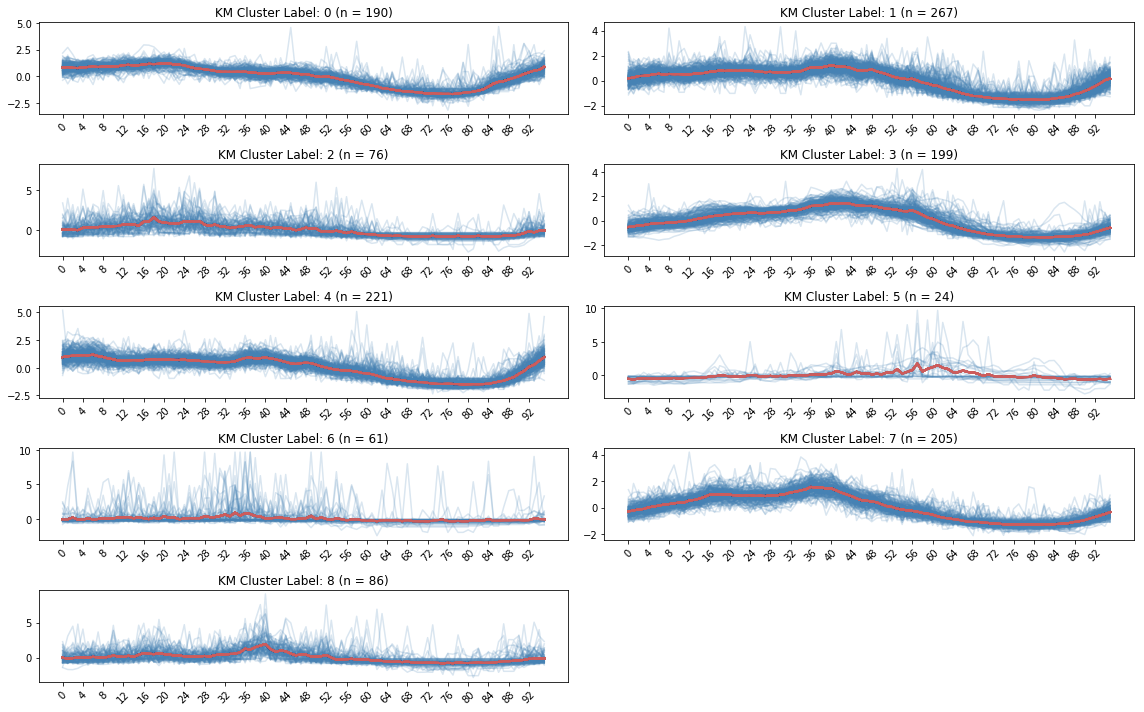

In [15]:
n_timesteps = 96
n_features = 97
plotKM(taz_quarterly, n_timesteps, n_features, 9)

# LightGBM

In [198]:
data_ = data.merge(taz_quarterly[['label_km9']], how='left', left_on='geohash6', right_index=True)
data_ = data_.merge(taz_daily[['label_km9']], how='left', left_on='geohash6', right_index=True)
data_['lon'], data_['lat'] = zip(*[(latlon[1], latlon[0]) for latlon in data_['geohash6'].map(geohash.decode)])
data_['hour'] = data_['time'].apply(lambda x: x.hour)
data_['timestep'] = data_['time'].apply(lambda x: (x.hour * 60 + x.minute) / 15 + 1) + (data_['day'] - 1) * 96

In [199]:
data_ = data_.sort_values(['geohash6', 'timestep'])

max_ts = int(data_['timestep'].max())
timesteps = list(range(1, max_ts+1))
full_df = pd.concat([pd.DataFrame({'geohash6': gh, 'timestep': timesteps}) for gh in data_['geohash6'].unique()])
full_df = full_df.merge(data_, how='left', on=['geohash6', 'timestep'])

In [200]:
def get_history(df, periods):
    tmp = pd.DataFrame.shift(df[['demand']], periods=periods)
    tmp.loc[~df['same_zone'], 'demand'] = -1
    df['demand_t-%s'%periods] = tmp
    df['demand_t-%s'%periods].fillna(-1, inplace=True)
    return df

In [201]:
tmp = [False]
tmp.extend(list(full_df['geohash6'][1:].values == full_df['geohash6'][:-1].values))
full_df['same_zone'] = tmp

full_df = get_history(full_df, 1)
full_df = get_history(full_df, 5)
full_df = get_history(full_df, 96)
full_df = get_history(full_df, 96*7)

In [202]:
full_df['am_peak'] = ((full_df['hour'] >= 22) | (full_df['hour'] <= 2)).astype(int)
full_df['midnight'] = ((full_df['hour'] >= 17) & (full_df['hour'] < 22)).astype(int)

full_df.head()

geohash6  timestep  day timestamp  demand date time datetime  dow  \
0   qp02yc         1  NaN       NaN     NaN  NaT  NaN      NaT  NaN   
1   qp02yc         2  NaN       NaN     NaN  NaT  NaN      NaT  NaN   
2   qp02yc         3  NaN       NaN     NaN  NaT  NaN      NaT  NaN   
3   qp02yc         4  NaN       NaN     NaN  NaT  NaN      NaT  NaN   
4   qp02yc         5  NaN       NaN     NaN  NaT  NaN      NaT  NaN   

   label_km9_x    ...     lon  lat  hour  same_zone  demand_t-1  demand_t-5  \
0          NaN    ...     NaN  NaN   NaN      False        -1.0        -1.0   
1          NaN    ...     NaN  NaN   NaN       True        -1.0        -1.0   
2          NaN    ...     NaN  NaN   NaN       True        -1.0        -1.0   
3          NaN    ...     NaN  NaN   NaN       True        -1.0        -1.0   
4          NaN    ...     NaN  NaN   NaN       True        -1.0        -1.0   

   demand_t-96  demand_t-672  am_peak  midnight  
0         -1.0          -1.0        0         0  
1         -1.0          -1.0        0         0  
2         -1.0          -1.0        0         0  
3         -1.0          -1.0        0         0  
4         -1.0          -1.0        0         0  

[5 rows x 21 columns]

In [257]:
features = ['day', 'hour', 'timestep', 'dow', 'label_km9_x', 'label_km9_y', 'lon', 'lat', 'am_peak', 'midnight', 'demand_t-1', 'demand_t-5', 'demand_t-96', 'demand_t-672']
features.extend(['demand'])
X = full_df.dropna(subset=['day'])[features]
X.head()

day  hour  timestep  dow  label_km9_x  label_km9_y        lon       lat  \
11  1.0   2.0        12  1.0          2.0          2.0  90.653687 -5.484924   
12  1.0   3.0        13  1.0          2.0          2.0  90.653687 -5.484924   
16  1.0   4.0        17  1.0          2.0          2.0  90.653687 -5.484924   
18  1.0   4.0        19  1.0          2.0          2.0  90.653687 -5.484924   
27  1.0   6.0        28  1.0          2.0          2.0  90.653687 -5.484924   

    am_peak  midnight  demand_t-1  demand_t-5  demand_t-96  demand_t-672  \
11        1         0   -1.000000   -1.000000         -1.0          -1.0   
12        0         0    0.020592   -1.000000         -1.0          -1.0   
16        0         0   -1.000000    0.020592         -1.0          -1.0   
18        0         0   -1.000000   -1.000000         -1.0          -1.0   
27        0         0   -1.000000   -1.000000         -1.0          -1.0   

      demand  
11  0.020592  
12  0.010292  
16  0.006676  
18  0.003822  
27  0.011131

In [258]:
X = X[X['label_km9_x'] == 3]

In [259]:
X_train = X[X['day'] <= 47]
X_test = X[X['day'] > 47]

X_val = X_train[X_train['day'] > 40]
X_train = X_train[X_train['day'] <= 40]

y_train = X_train.pop('demand')
y_test = X_test.pop('demand')
y_val = X_val.pop('demand')

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(595512, 14)
(108693, 14)
(215436, 14)
(595512,)
(108693,)
(215436,)


In [260]:
X_train.loc[X_train.sample(frac=0.4).index, 'demand_t-1'] = -1
X_train.loc[X_train.sample(frac=0.1).index, 'demand_t-5'] = -1

In [261]:
import lightgbm as lgb
def eval_RMSE(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    assert len(y_true) == len(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(rmse)

In [262]:
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression',
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'rmse',
    'num_threads': 4
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = ['hour', 'label_km9_x']

print("=" * 50)
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_vars)
dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_vars, reference=dtrain)
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,
                valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=50
)
print("\n".join(("%s: %.2f" % x) for x in sorted(
    zip(X_train.columns, bst.feature_importance("gain")),
    key=lambda x: x[1], reverse=True
)))

/home/yuwen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/yuwen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.0523694	valid_1's rmse: 0.0475455
[100]	training's rmse: 0.0498197	valid_1's rmse: 0.0470315
[150]	training's rmse: 0.0486671	valid_1's rmse: 0.0468677
[200]	training's rmse: 0.0479253	valid_1's rmse: 0.0469197
[250]	training's rmse: 0.0473052	valid_1's rmse: 0.0471316
Early stopping, best iteration is:
[150]	training's rmse: 0.0486671	valid_1's rmse: 0.0468677
demand_t-96: 59388.54
demand_t-5: 38440.30
demand_t-672: 11137.98
demand_t-1: 10646.55
timestep: 785.74
hour: 717.55
dow: 687.39
day: 534.99
lon: 196.90
lat: 102.35
label_km9_y: 41.74
am_peak: 12.79
midnight: 10.57
label_km9_x: 0.00


In [263]:
# train
y_pred = bst.predict(X_train)
eval_RMSE(y_train, y_pred)
# validate
y_pred = bst.predict(X_val)
eval_RMSE(y_val, y_pred)
# test
y_pred = bst.predict(X_test)
eval_RMSE(y_test, y_pred)

0.04866713327622557
0.04686772703941218
0.045405464474497385


In [264]:
X_test.loc[X_test['day'] > 55, 'demand_t-1'] = -1
# X_test.loc[X_test['day'] > 55, 'demand_t-5'] = -1

/home/yuwen/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [265]:
# test
y_pred = bst.predict(X_test)
eval_RMSE(y_test, y_pred)

0.05291182421852598


In [266]:
result = pd.concat([X_test.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]
print(result.shape)
result.head()

(215436, 17)


day  hour  timestep  dow  label_km9_x  label_km9_y        lon       lat  \
0  48.0   0.0      4514  6.0          3.0          2.0  90.664673 -5.473938   
1  48.0   0.0      4516  6.0          3.0          2.0  90.664673 -5.473938   
2  48.0   1.0      4517  6.0          3.0          2.0  90.664673 -5.473938   
3  48.0   4.0      4529  6.0          3.0          2.0  90.664673 -5.473938   
4  48.0   5.0      4534  6.0          3.0          2.0  90.664673 -5.473938   

   am_peak  midnight  demand_t-1  demand_t-5  demand_t-96  demand_t-672  \
0        1         0   -1.000000   -1.000000         -1.0          -1.0   
1        1         0   -1.000000   -1.000000         -1.0          -1.0   
2        1         0    0.023405   -1.000000         -1.0          -1.0   
3        0         0   -1.000000   -1.000000         -1.0          -1.0   
4        0         0   -1.000000    0.033073         -1.0          -1.0   

     y_test    y_pred geohash6  
0  0.007949  0.013794   qp02z5  
1  0.023405  0.013794   qp02z5  
2  0.017782  0.014824   qp02z5  
3  0.033073  0.014409   qp02z5  
4  0.044624  0.018192   qp02z5

In [268]:
result[result['label_km9_x'] == 3].head()

day  hour  timestep  dow  label_km9_x  label_km9_y        lon       lat  \
0  48.0   0.0      4514  6.0          3.0          2.0  90.664673 -5.473938   
1  48.0   0.0      4516  6.0          3.0          2.0  90.664673 -5.473938   
2  48.0   1.0      4517  6.0          3.0          2.0  90.664673 -5.473938   
3  48.0   4.0      4529  6.0          3.0          2.0  90.664673 -5.473938   
4  48.0   5.0      4534  6.0          3.0          2.0  90.664673 -5.473938   

   am_peak  midnight  demand_t-1  demand_t-5  demand_t-96  demand_t-672  \
0        1         0   -1.000000   -1.000000         -1.0          -1.0   
1        1         0   -1.000000   -1.000000         -1.0          -1.0   
2        1         0    0.023405   -1.000000         -1.0          -1.0   
3        0         0   -1.000000   -1.000000         -1.0          -1.0   
4        0         0   -1.000000    0.033073         -1.0          -1.0   

     y_test    y_pred geohash6  
0  0.007949  0.013794   qp02z5  
1  0.023405  0.013794   qp02z5  
2  0.017782  0.014824   qp02z5  
3  0.033073  0.014409   qp02z5  
4  0.044624  0.018192   qp02z5

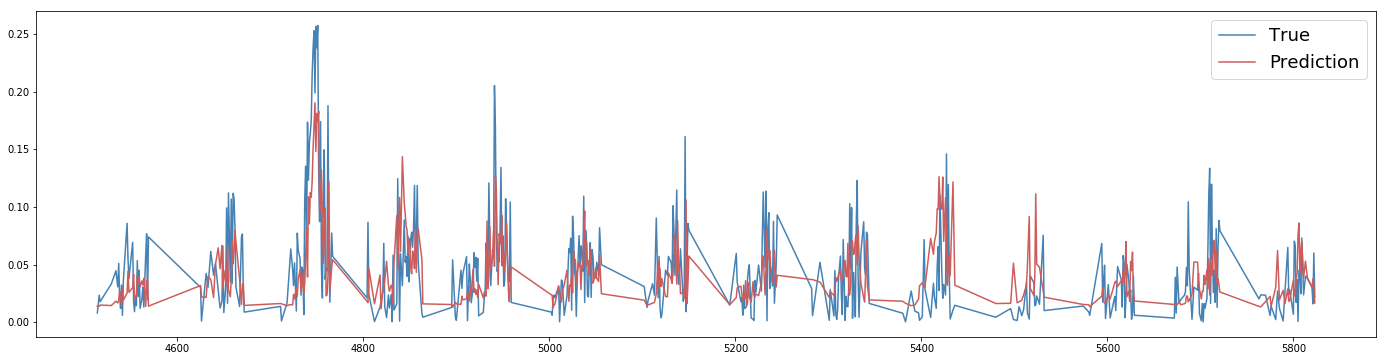

In [269]:
# t-1, t-5, t-1D, t-7D
gh = 'qp02z5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

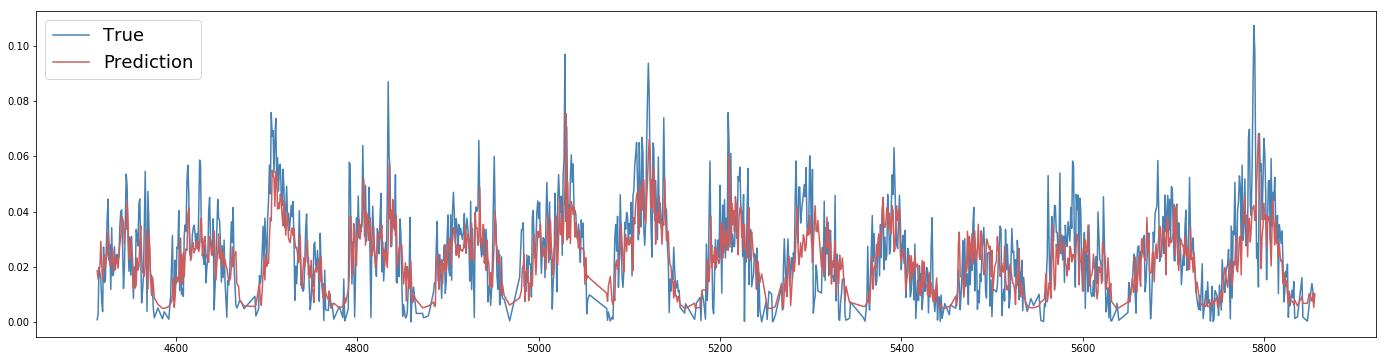

In [256]:
# t-1, t-5, t-1D, t-7D (km_label_x == 0)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

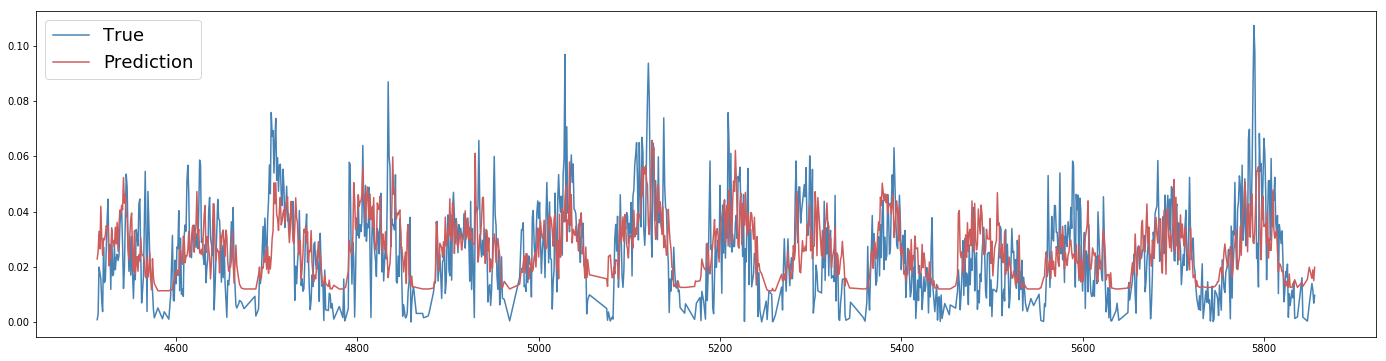

In [220]:
# t-5, t-1D, t-7D
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

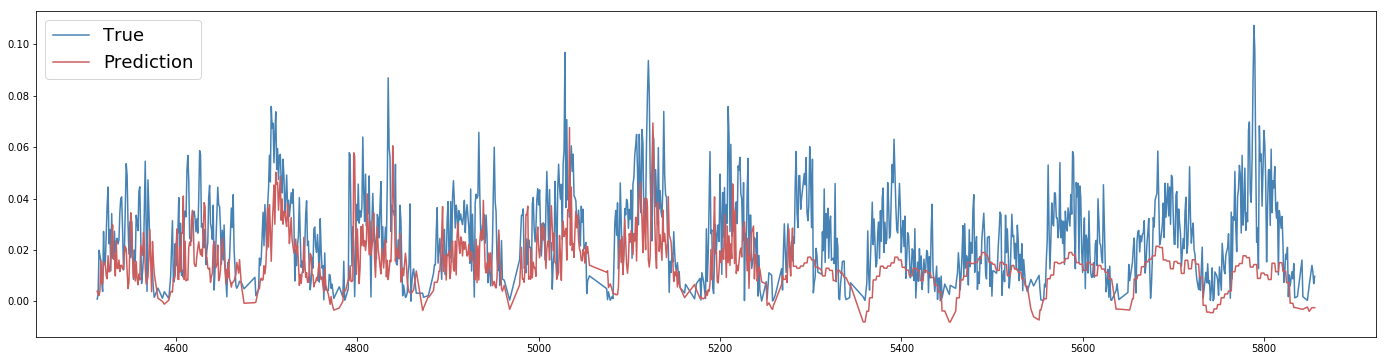

In [176]:
# clustering as cate
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

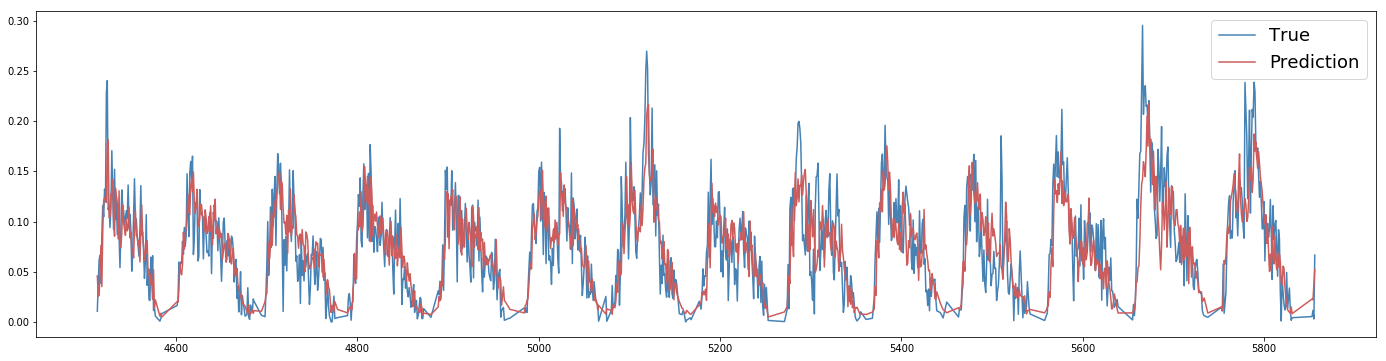

In [231]:
# t-1, t-5, t-1D, t-7D
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

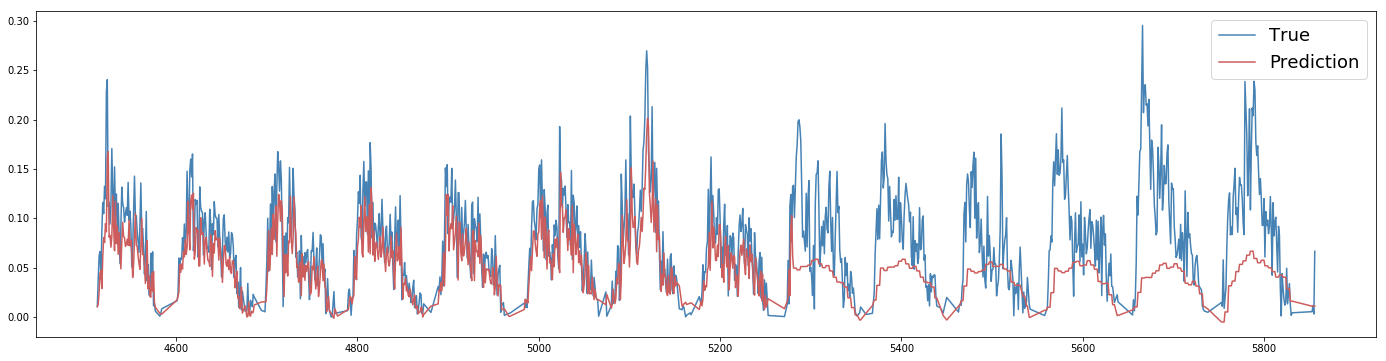

In [160]:
# clustering as cate
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

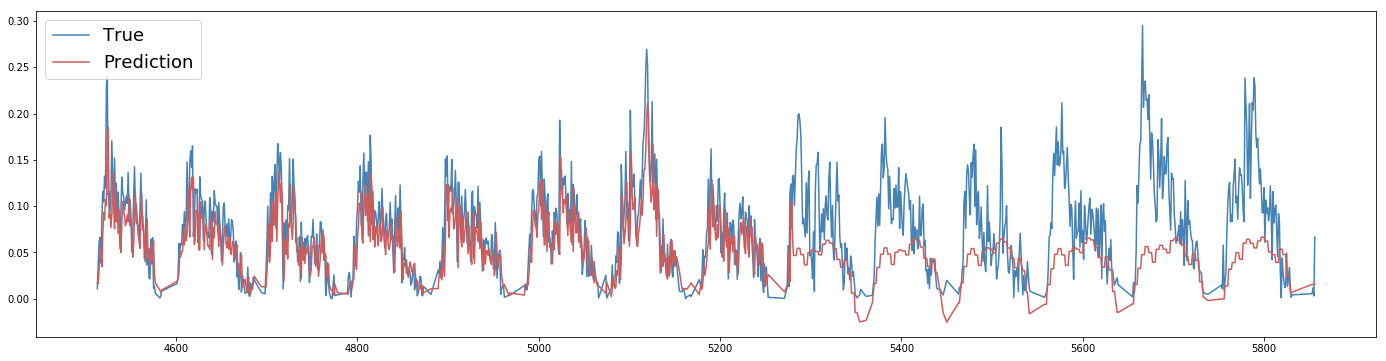

In [128]:
# dow as cate
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

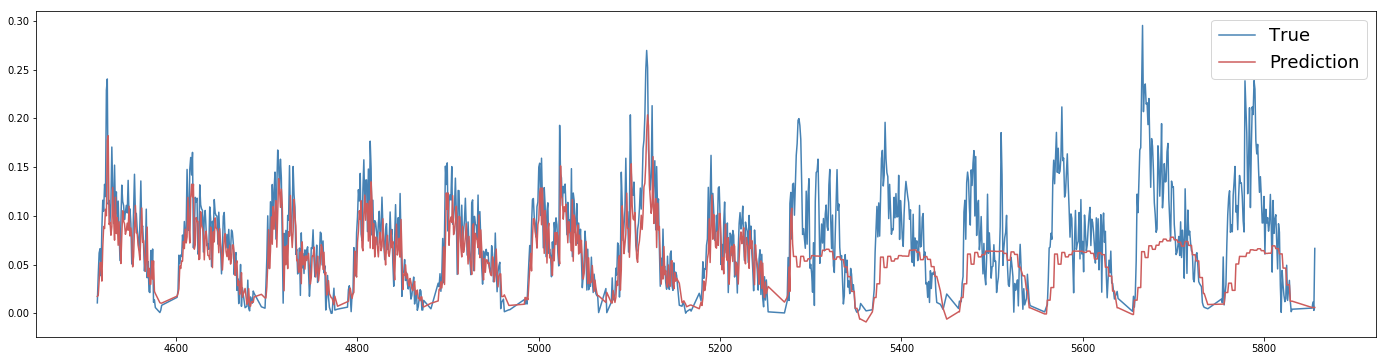

In [123]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

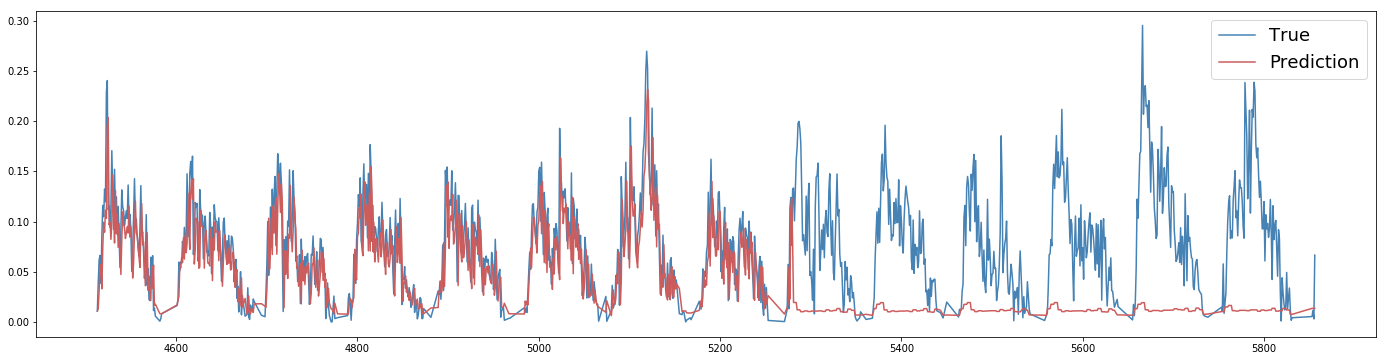

In [110]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

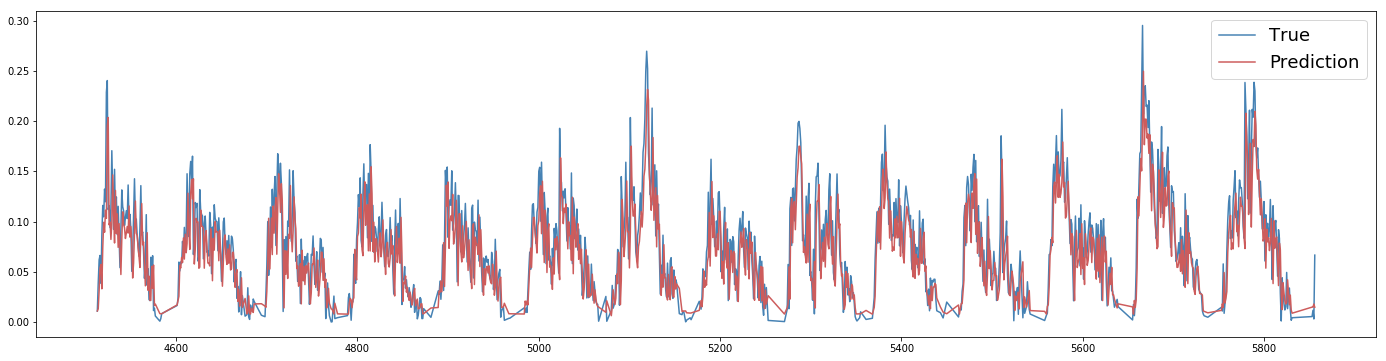

In [102]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

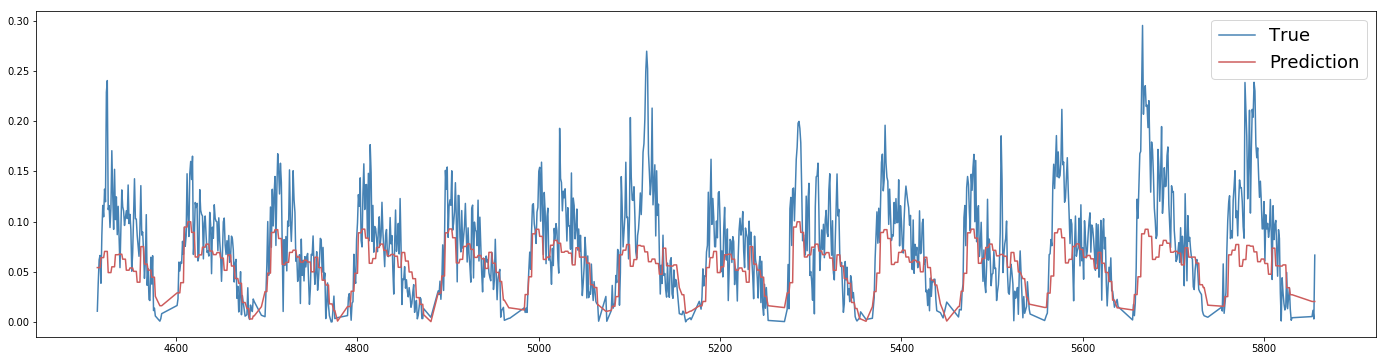

In [70]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

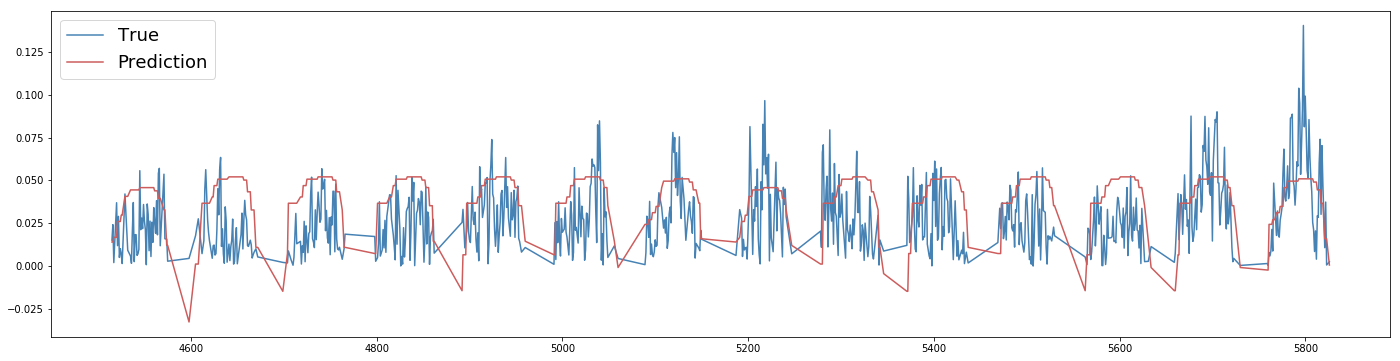

In [148]:
gh = 'qp091w'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())